## Two-Stream Adaptive Graph Convolutional Network
Model with temporal attention and spatial attention combined with a graph learning layer. <br />
Spatial attention is performed before temporal attention. <br />

The last layer returns the output of the last layer without an output module.<br />

The definition in PyTorch Geometric Temporal performs *view* operations on non-contiguous tensors.<br />
Small fix applied in the following code.<br />
<br />

### AAGCN Modified

In [6]:
import math
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from torch_geometric.utils.to_dense_adj import to_dense_adj
import torch.nn.functional as F


class GraphAAGCN:
    r"""
    Defining the Graph for the Two-Stream Adaptive Graph Convolutional Network.
    It's composed of the normalized inward-links, outward-links and
    self-links between the nodes as originally defined in the
    `authors repo  <https://github.com/lshiwjx/2s-AGCN/blob/master/graph/tools.py>`
    resulting in the shape of (3, num_nodes, num_nodes).
    Args:
        edge_index (Tensor array): Edge indices
        num_nodes (int): Number of nodes
    Return types:
            * **A** (PyTorch Float Tensor) - Three layer normalized adjacency matrix
    """

    def __init__(self, edge_index: list, num_nodes: int):
        self.num_nodes = num_nodes
        self.edge_index = edge_index
        self.A = self.get_spatial_graph(self.num_nodes)

    def get_spatial_graph(self, num_nodes):
        self_mat = torch.eye(num_nodes)
        inward_mat = torch.squeeze(to_dense_adj(self.edge_index))
        inward_mat_norm = F.normalize(inward_mat, dim=0, p=1)
        outward_mat = inward_mat.transpose(0, 1)
        outward_mat_norm = F.normalize(outward_mat, dim=0, p=1)
        adj_mat = torch.stack((self_mat, inward_mat_norm, outward_mat_norm))
        return adj_mat


class UnitTCN(nn.Module):
    r"""
    Temporal Convolutional Block applied to nodes in the Two-Stream Adaptive Graph
    Convolutional Network as originally implemented in the
    `Github Repo <https://github.com/lshiwjx/2s-AGCN>`. For implementational details
    see https://arxiv.org/abs/1805.07694
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size. (default: :obj:`9`)
        stride (int): Temporal Convolutional kernel stride. (default: :obj:`1`)
    """

    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int = 9, stride: int = 1
    ):
        super(UnitTCN, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            padding=(pad, 0),
            stride=(stride, 1),
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self._conv_init(self.conv)
        self._bn_init(self.bn, 1)

    def _bn_init(self, bn, scale):
        nn.init.constant_(bn.weight, scale)
        nn.init.constant_(bn.bias, 0)

    def _conv_init(self, conv):
        nn.init.kaiming_normal_(conv.weight, mode="fan_out")
        nn.init.constant_(conv.bias, 0)

    def forward(self, x):
        x = self.bn(self.conv(x))
        return x


class UnitGCN(nn.Module):
    r"""
    Graph Convolutional Block applied to nodes in the Two-Stream Adaptive Graph Convolutional
    Network as originally implemented in the `Github Repo <https://github.com/lshiwjx/2s-AGCN>`.
    For implementational details see https://arxiv.org/abs/1805.07694.
    Temporal attention, spatial attention and channel-wise attention will be applied.
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        A (Tensor array): Adaptive Graph.
        coff_embedding (int, optional): Coefficient Embeddings. (default: :int:`4`)
        num_subset (int, optional): Subsets for adaptive graphs, see
        :math:`\mathbf{A}, \mathbf{B}, \mathbf{C}` in https://arxiv.org/abs/1805.07694
        for details. (default: :int:`3`)
        adaptive (bool, optional): Apply Adaptive Graph Convolutions. (default: :obj:`True`)
        attention (bool, optional): Apply Attention. (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        A: torch.FloatTensor,
        coff_embedding: int = 4,
        num_subset: int = 3,
        adaptive: bool = True,
        attention: bool = True,
    ):
        super(UnitGCN, self).__init__()
        self.inter_c = out_channels // coff_embedding
        self.out_c = out_channels
        self.in_c = in_channels
        self.num_subset = num_subset
        self.A = A
        self.num_jpts = A.shape[-1]
        self.attention = attention
        self.adaptive = adaptive

        self.conv_d = nn.ModuleList()

        for i in range(self.num_subset):
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))

        if self.adaptive:
            self._init_adaptive_layers()
        else:
            self.A = Variable(self.A, requires_grad=False)

        if self.attention:
            self._init_attention_layers()

        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1), nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x

        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.tan = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

        self._init_conv_bn()

    def _bn_init(self, bn, scale):
        nn.init.constant_(bn.weight, scale)
        nn.init.constant_(bn.bias, 0)

    def _conv_init(self, conv):
        nn.init.kaiming_normal_(conv.weight, mode="fan_out")
        nn.init.constant_(conv.bias, 0)

    def _conv_branch_init(self, conv, branches):
        weight = conv.weight
        n = weight.size(0)
        k1 = weight.size(1)
        k2 = weight.size(2)
        nn.init.normal_(weight, 0, math.sqrt(2.0 / (n * k1 * k2 * branches)))
        nn.init.constant_(conv.bias, 0)

    def _init_conv_bn(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                self._conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                self._bn_init(m, 1)
        self._bn_init(self.bn, 1e-6)

        for i in range(self.num_subset):
            self._conv_branch_init(self.conv_d[i], self.num_subset)

    def _init_attention_layers(self):
        # temporal attention
        self.conv_ta = nn.Conv1d(self.out_c, 1, 9, padding=4)
        nn.init.constant_(self.conv_ta.weight, 0)
        nn.init.constant_(self.conv_ta.bias, 0)

        # s attention
        ker_jpt = self.num_jpts - 1 if not self.num_jpts % 2 else self.num_jpts
        pad = (ker_jpt - 1) // 2
        self.conv_sa = nn.Conv1d(self.out_c, 1, ker_jpt, padding=pad)
        nn.init.xavier_normal_(self.conv_sa.weight)
        nn.init.constant_(self.conv_sa.bias, 0)

        # channel attention
        rr = 2
        self.fc1c = nn.Linear(self.out_c, self.out_c // rr)
        self.fc2c = nn.Linear(self.out_c // rr, self.out_c)
        nn.init.kaiming_normal_(self.fc1c.weight)
        nn.init.constant_(self.fc1c.bias, 0)
        nn.init.constant_(self.fc2c.weight, 0)
        nn.init.constant_(self.fc2c.bias, 0)

    def _init_adaptive_layers(self):
        self.PA = nn.Parameter(self.A)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(self.in_c, self.inter_c, 1))
            self.conv_b.append(nn.Conv2d(self.in_c, self.inter_c, 1))

    def _attentive_forward(self, y):
        # spatial attention
        se = y.mean(-2)  # N C V
        se1 = self.sigmoid(self.conv_sa(se))
        y = y * se1.unsqueeze(-2) + y

        # temporal attention
        se = y.mean(-1)
        se1 = self.sigmoid(self.conv_ta(se))
        y = y * se1.unsqueeze(-1) + y

        # channel attention
        se = y.mean(-1).mean(-1)
        se1 = self.relu(self.fc1c(se))
        se2 = self.sigmoid(self.fc2c(se1))
        y = y * se2.unsqueeze(-1).unsqueeze(-1) + y

        return y

    def _adaptive_forward(self, x, y):
        N, C, T, V = x.size()
        
        A = self.PA
        for i in range(self.num_subset):
            A1 = (
                self.conv_a[i](x)
                .permute(0, 3, 1, 2)
                .contiguous()
                .view(N, V, self.inter_c * T)
            )
            A2 = self.conv_b[i](x)
            A2 = A2.contiguous().view(N, -1 , V)
            A1 = self.tan(torch.matmul(A1, A2) / A1.size(-1))  # N V V
            A1 = A[i] + A1 * self.alpha
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z

        return y

    def _non_adaptive_forward(self, x, y):
        N, C, T, V = x.size()
        for i in range(self.num_subset):
            A1 = self.A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        return y

    def forward(self, x):
        N, C, T, V = x.size()

        y = None
        if self.adaptive:
            y = self._adaptive_forward(x, y)
        else:
            y = self._non_adaptive_forward(x, y)
        y = self.bn(y)
        y += self.down(x)
        y = self.relu(y)
        if self.attention:
            y = self._attentive_forward(y)
        return y


class AAGCN(nn.Module):
    r"""Two-Stream Adaptive Graph Convolutional Network.
    For details see this paper: `"Two-Stream Adaptive Graph Convolutional Networks for
    Skeleton-Based Action Recognition." <https://arxiv.org/abs/1805.07694>`_.
    This implementation is based on the authors Github Repo https://github.com/lshiwjx/2s-AGCN.
    It's used by the author for classifying actions from sequences of 3D body joint coordinates.
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        edge_index (PyTorch LongTensor): Graph edge indices.
        num_nodes (int): Number of nodes in the network.
        stride (int, optional): Time strides during temporal convolution. (default: :obj:`1`)
        residual (bool, optional): Applying residual connection. (default: :obj:`True`)
        adaptive (bool, optional): Adaptive node connection weights. (default: :obj:`True`)
        attention (bool, optional): Applying spatial-temporal-channel-attention.
        (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_index: torch.LongTensor,
        num_nodes: int,
        stride: int = 1,
        residual: bool = True,
        adaptive: bool = True,
        attention: bool = True,
    ):
        super(AAGCN, self).__init__()
        self.edge_index = edge_index
        self.num_nodes = num_nodes

        self.graph = GraphAAGCN(self.edge_index, self.num_nodes)
        self.A = self.graph.A

        self.gcn1 = UnitGCN(
            in_channels, out_channels, self.A, adaptive=adaptive, attention=attention
        )
        self.tcn1 = UnitTCN(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        self.attention = attention

        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = UnitTCN(
                in_channels, out_channels, kernel_size=1, stride=stride
            )

    def forward(self, x):
        """
        Making a forward pass.
        Arg types:
            * **X** (PyTorch FloatTensor) - Node features for T time periods,
            with shape (B, F_in, T_in, N_nodes).
        Return types:
            * **X** (PyTorch FloatTensor)* - Sequence of node features,
            with shape (B, out_channels, T_in//stride, N_nodes).
        """
        y = self.relu(self.tcn1(self.gcn1(x)) + self.residual(x))
        return y

### Multi-Layer AAGCN

100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


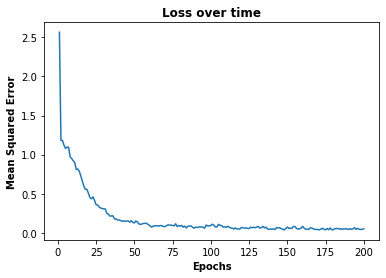

Train MSE: 0.0515
Test MSE: 1.1463


In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
# from torch_geometric_temporal.nn.attention import AAGCN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)
edge_index = sample.edge_index

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self):
        super(AttentionGCN, self).__init__()

        layer_out_channels = [32, 32, 64, 64]

        self.aagcn = nn.ModuleList()
        for i, out_dim in enumerate(layer_out_channels):
            in_dim = 1 if i == 0 else layer_out_channels[i-1]
            self.aagcn.append(
                AAGCN(
                in_channels=in_dim,
                out_channels=out_dim,
                edge_index=edge_index,
                num_nodes=num_nodes,
                stride=1,
                residual=True,
                adaptive=True,
                attention=True
                )
            )

        # self.out = nn.Linear(out_dim*lags, 1)
        self.out = nn.Linear(out_dim, 1)
    
        self.bn = nn.BatchNorm1d(lags)
        self.dropout = nn.Dropout(0.2)


    def forward(self, window):
        x = window.x.view(-1, lags, num_nodes)
        x = self.bn(x).unsqueeze(1)

        for layer in self.aagcn:
            x = layer(x)

        x = x.mean(2).permute(0,2,1) 
        x = self.dropout(x)
        out = self.out(x).flatten()
        return out
    
model = AttentionGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
